# Comparing the impacts of random and non-random matches on the triangle plots

Per discussion with J and R March 18:  
    Request to understand the impacts of random and non-random choices on the triangle trend plots
    
### Approach:  
Choose models with both random and non-random matches; Do plots with just random, plots with just non-random and plots with both  
Models of choice: CanESM5, GISS-E2-1-G

In [4]:
%reset -f

In [5]:
%load_ext autoreload

In [6]:
%reload_ext autoreload
%autoreload 2

In [7]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore
import random

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# systems functions
import os
from collections import defaultdict
from datetime import date

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient, Gradient
from GradTrendClasses import CalcMMEGradSubset
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology, DictToDf, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, ClassifyModels
from GradientProjectFunctions import CalculateModelRange, CalculateObsPercentile, CreateScenarioDictionary, ExtendPeriod, ConcatModels, ClassifyHistModelsLite, MakeChangeDir

#### Outputs

In [8]:
#_____Plots________
pathBase = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/'
plotsEnd = 'Plots_MASTER_ScenarioMatchRNR'

plotsDir = pathBase + plotsEnd

#### Inputs

In [9]:
#____Stats______
statsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Model_Statistics'

#_____Gradients_____
gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_MASTER'

# inputting from a csv file
openDapDir = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

## Reading in the trend information for the models that are random and not

In [45]:
modelList = ['CanESM5', 'GISS-E2-1-G', 'IPSL-CM6A-LR']

# importing the match file
fileName = 'Match_data_Top8.csv'

os.chdir(statsDir)
matchData = pd.read_csv(fileName, index_col = 0)

# create a list of model names that are random and those that aren't
# creating a new column with the model name (note that these are all before the first _)
models = []
for modelName in list(matchData.index):
    charIndex = modelName.index('_')
    models.append(modelName[:charIndex])
    
matchData['Model'] = models
matchData = matchData.reindex(columns = ['Model', 'ScenModel', 'Assignment']);

### Bootstrapping

Per Jason's suggestion: we need to be comparing similar batch sizes of random and non-random assignments so that MME trend magnitudes are comparable

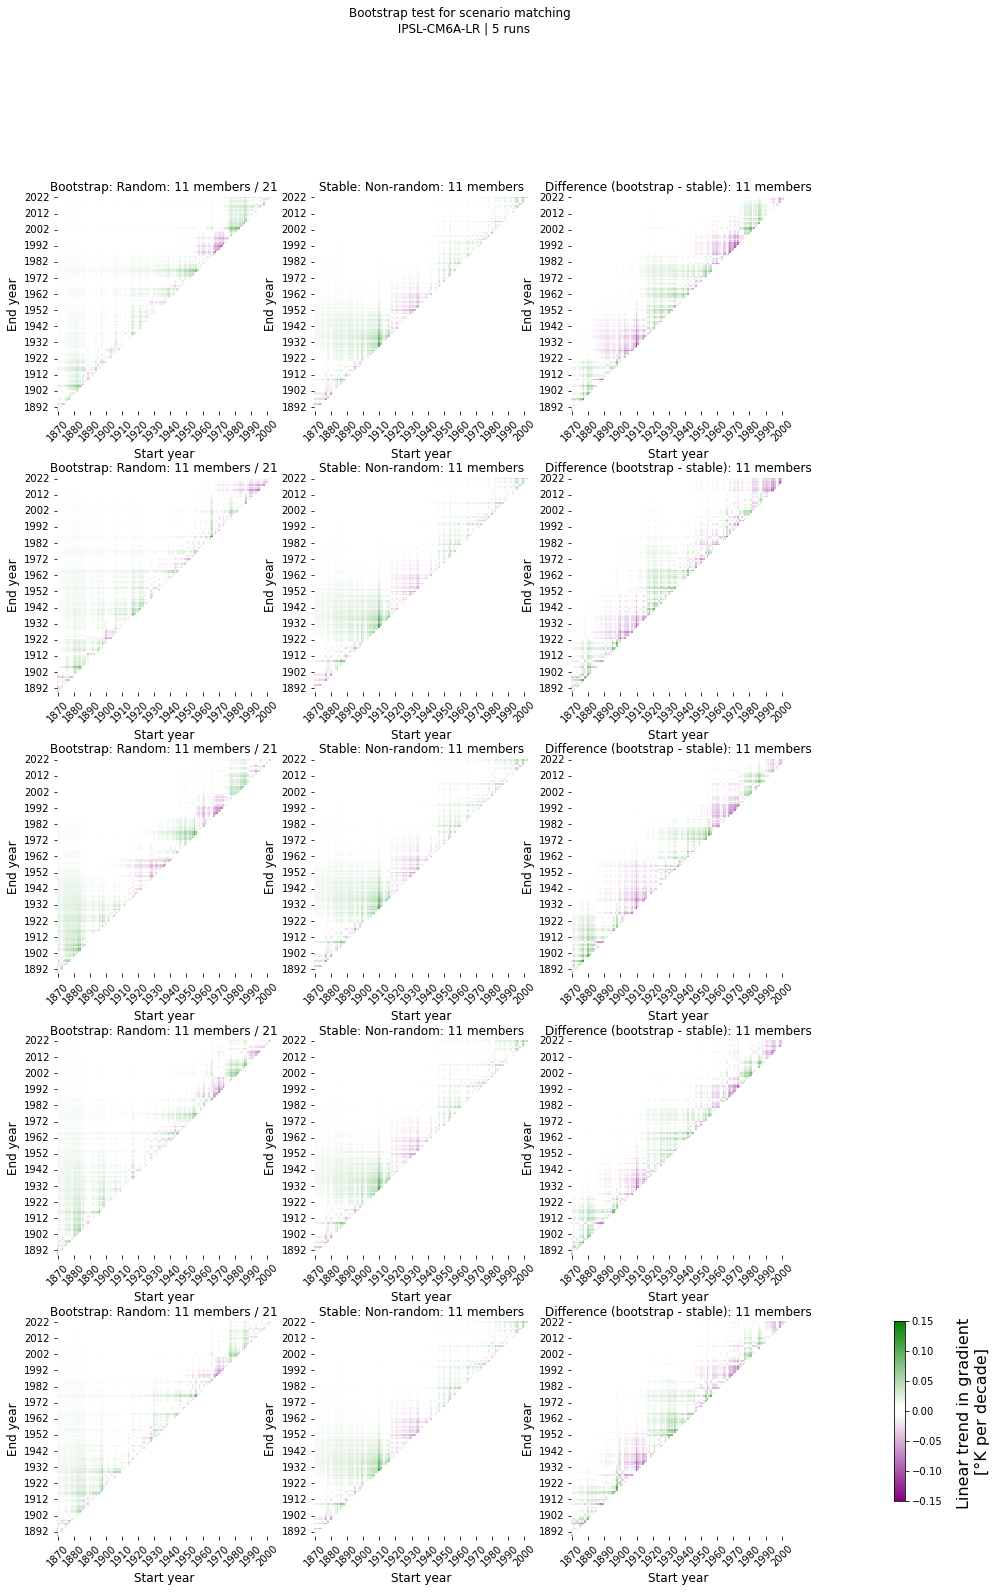

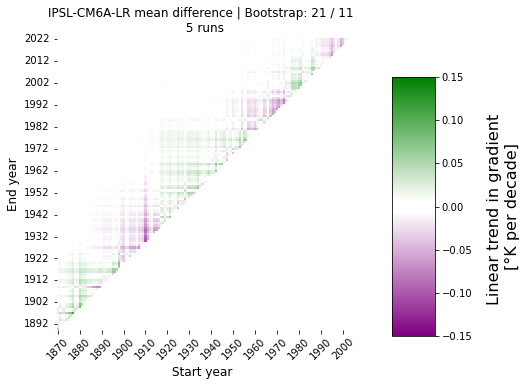

In [46]:
# setting vmin and vmax for each model
colorLims = {'CanESM5': -0.03, 'GISS-E2-1-G': -0.05, 'IPSL-CM6A-LR': -0.03}

N = 10 # number of times to bootstrap

for model in modelList:
    countRandom = matchData[matchData.Model == model].groupby('Assignment').count().Model.loc['Random']
    countNonRandom = matchData[matchData.Model == model].groupby('Assignment').count().Model.loc['Non-random']

    # setting the path depending on which is larger
    if countRandom > countNonRandom:
        assignmentBS = 'Random'
        assignmentStable = 'Non-random'
        countBS = countRandom
        countStable = countNonRandom

    else:
        assignmentBS = 'Non-random'
        assignmentStable = 'Random'
        countBS = countNonRandom
        countStable = countRandom
        
    # TEMP setting up a list to store the trend values of all of these so that we can calculate the right range for the colorbar
    trendsAll = []

    # setting up the figures for plotting
    nCols = 3
    nRows = N

    subplotSize = (5, 5)
    figWidth = nCols * subplotSize[0]
    figHeight = nRows * subplotSize[1]

    # plotting settings
    vmin = colorLims[model]
    vmax = -vmin

    # setting the colorbar
    colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
    cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)


    fig, axes = plt.subplots(ncols = nCols, nrows = nRows, figsize = (figWidth, figHeight))
    fig.suptitle(f'Bootstrap test for scenario matching \n {model} | {N} runs')

    
    for n in np.arange(N):
        dictBS = defaultdict(list)
        dictStable = defaultdict(list)

        # selecting a subset of some of the models for the bootstrapping
        dictBS[model].append(random.sample(list(matchData[(matchData.Assignment == assignmentBS) & (matchData.Model == model)].index), countStable))
        dictStable[model].append(list(matchData[(matchData.Assignment == assignmentStable) & (matchData.Model == model)].index))

        dictBS = dict(dictBS)
        dictStable = dict(dictStable)

        #------------------
        # BS calc and plot
        #------------------

        # calculating the trends
        listSubset = dictBS[model][0]
        gradientMean = CalcMMEGradSubset(gradientsDir, model, listSubset)
        trends = Trend(gradientMean).trends
        trendsDf = Trend(gradientMean).trendsDf
        
        # TEMP saving out the trends
        trendsAll += list(trends.values())

        offset = 20 # years
        trendsDfCropBS = CropTrendsDf(trendsDf, offset)

        plotNum = 0
        axes[n, plotNum].set_title(f'Bootstrap: {assignmentBS}: {len(listSubset)} members / {countBS}', fontsize = 12)
        axes[n, plotNum].set_aspect('equal')
        plot = sns.heatmap(trendsDfCropBS, cmap = cmap, ax = axes[n, plotNum], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
        axes[n, plotNum].tick_params(axis = 'x', rotation = 45)
        axes[n, plotNum].tick_params(axis = 'y', rotation = 0)
        axes[n, plotNum].set_ylabel('End year', fontsize = 12)
        axes[n, plotNum].set_xlabel('Start year', fontsize = 12)

        #------------------
        # Stable calc and plot
        #------------------

        # calculating the trends
        listSubset = dictStable[model][0]
        gradientMean = CalcMMEGradSubset(gradientsDir, model, listSubset)
        trends = Trend(gradientMean).trends
        trendsDf = Trend(gradientMean).trendsDf
        
        # TEMP saving out the trends
        trendsAll += list(trends.values())

        offset = 20 # years
        trendsDfCropStable = CropTrendsDf(trendsDf, offset)

        plotNum = 1
        axes[n, plotNum].set_title(f'Stable: {assignmentStable}: {len(listSubset)} members', fontsize = 12)
        axes[n, plotNum].set_aspect('equal')
        plot = sns.heatmap(trendsDfCropStable, cmap = cmap, ax = axes[n, plotNum], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
        axes[n, plotNum].tick_params(axis = 'x', rotation = 45)
        axes[n, plotNum].tick_params(axis = 'y', rotation = 0)
        axes[n, plotNum].set_ylabel('End year', fontsize = 12)
        axes[n, plotNum].set_xlabel('Start year', fontsize = 12)

        #------------------
        # Difference calc and plot
        #------------------

        trendsDfCropDiff = trendsDfCropBS - trendsDfCropStable

        plotNum = 2
        axes[n, plotNum].set_title(f'Difference (bootstrap - stable): {len(listSubset)} members', fontsize = 12)
        axes[n, plotNum].set_aspect('equal')
        plot = sns.heatmap(trendsDfCropDiff, cmap = cmap, ax = axes[n, plotNum], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
        axes[n, plotNum].tick_params(axis = 'x', rotation = 45)
        axes[n, plotNum].tick_params(axis = 'y', rotation = 0)
        axes[n, plotNum].set_ylabel('End year', fontsize = 12)
        axes[n, plotNum].set_xlabel('Start year', fontsize = 12)
        
        #------------------
        # taking the sum of the differences
        #------------------
        if (n == 0):
            dfTotalDiff = trendsDfCropDiff

        else:
            dfTotalDiff += trendsDfCropDiff

    plt.subplots_adjust(right = 0.8)
    
    cbarAx = fig.add_axes([0.9, 0.15, 0.01, 0.1])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

    MakeChangeDir(plotsDir)
    plt.savefig(f'{model}_RNR_Triangles_specificCB.png')
    
    #------------------
    # taking the mean of the differences
    #------------------
    dfTotalMean = dfTotalDiff/N
    
    fig, ax = plt.subplots(figsize = (6,6))
    ax.set_title(f'{model} mean difference | Bootstrap: {countBS} / {countStable} \n {N} runs', fontsize = 12)
    ax.set_aspect('equal')
    plot = sns.heatmap(dfTotalMean, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)
    
    plt.subplots_adjust(right = 0.8)
    
    cbarAx = fig.add_axes([0.9, 0.15, 0.05, 0.6])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)
        
    MakeChangeDir(plotsDir)
    plt.savefig(f'{model}_MeanDiff_specificCB.png')
    

In [ ]:
for model in modelList:
    countRandom = matchData[matchData.Model == model].groupby('Assignment').count().Model.loc['Random']
    countNonRandom = matchData[matchData.Model == model].groupby('Assignment').count().Model.loc['Non-random']

    # setting the path depending on which is larger
    if countRandom > countNonRandom:
        assignmentBS = 'Random'
        assignmentStable = 'Non-random'
        countBS = countRandom
        countStable = countNonRandom

    else:
        assignmentBS = 'Non-random'
        assignmentStable = 'Random'
        countBS = countNonRandom
        countStable = countRandom
        
    # TEMP setting up a list to store the trend values of all of these so that we can calculate the right range for the colorbar
    trendsAll = []

    # setting up the figures for plotting
    nCols = 3
    nRows = N

    subplotSize = (5, 5)
    figWidth = nCols * subplotSize[0]
    figHeight = nRows * subplotSize[1]

    # plotting settings
    vmin = -0.15
    vmax = -vmin

    # setting the colorbar
    colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
    cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)


    fig, axes = plt.subplots(ncols = nCols, nrows = nRows, figsize = (figWidth, figHeight))
    fig.suptitle(f'Bootstrap test for scenario matching \n {model} | {N} runs')

    
    for n in np.arange(N):
        dictBS = defaultdict(list)
        dictStable = defaultdict(list)

        # selecting a subset of some of the models for the bootstrapping
        dictBS[model].append(random.sample(list(matchData[(matchData.Assignment == assignmentBS) & (matchData.Model == model)].index), countStable))
        dictStable[model].append(list(matchData[(matchData.Assignment == assignmentStable) & (matchData.Model == model)].index))

        dictBS = dict(dictBS)
        dictStable = dict(dictStable)

        #------------------
        # BS calc and plot
        #------------------

        # calculating the trends
        listSubset = dictBS[model][0]
        gradientMean = CalcMMEGradSubset(gradientsDir, model, listSubset)
        trends = Trend(gradientMean).trends
        trendsDf = Trend(gradientMean).trendsDf
        
        # TEMP saving out the trends
        trendsAll += list(trends.values())

        offset = 20 # years
        trendsDfCropBS = CropTrendsDf(trendsDf, offset)

        plotNum = 0
        axes[n, plotNum].set_title(f'Bootstrap: {assignmentBS}: {len(listSubset)} members / {countBS}', fontsize = 12)
        axes[n, plotNum].set_aspect('equal')
        plot = sns.heatmap(trendsDfCropBS, cmap = cmap, ax = axes[n, plotNum], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
        axes[n, plotNum].tick_params(axis = 'x', rotation = 45)
        axes[n, plotNum].tick_params(axis = 'y', rotation = 0)
        axes[n, plotNum].set_ylabel('End year', fontsize = 12)
        axes[n, plotNum].set_xlabel('Start year', fontsize = 12)

        #------------------
        # Stable calc and plot
        #------------------

        # calculating the trends
        listSubset = dictStable[model][0]
        gradientMean = CalcMMEGradSubset(gradientsDir, model, listSubset)
        trends = Trend(gradientMean).trends
        trendsDf = Trend(gradientMean).trendsDf
        
        # TEMP saving out the trends
        trendsAll += list(trends.values())

        offset = 20 # years
        trendsDfCropStable = CropTrendsDf(trendsDf, offset)

        plotNum = 1
        axes[n, plotNum].set_title(f'Stable: {assignmentStable}: {len(listSubset)} members', fontsize = 12)
        axes[n, plotNum].set_aspect('equal')
        plot = sns.heatmap(trendsDfCropStable, cmap = cmap, ax = axes[n, plotNum], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
        axes[n, plotNum].tick_params(axis = 'x', rotation = 45)
        axes[n, plotNum].tick_params(axis = 'y', rotation = 0)
        axes[n, plotNum].set_ylabel('End year', fontsize = 12)
        axes[n, plotNum].set_xlabel('Start year', fontsize = 12)

        #------------------
        # Difference calc and plot
        #------------------

        trendsDfCropDiff = trendsDfCropBS - trendsDfCropStable

        plotNum = 2
        axes[n, plotNum].set_title(f'Difference (bootstrap - stable): {len(listSubset)} members', fontsize = 12)
        axes[n, plotNum].set_aspect('equal')
        plot = sns.heatmap(trendsDfCropDiff, cmap = cmap, ax = axes[n, plotNum], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
        axes[n, plotNum].tick_params(axis = 'x', rotation = 45)
        axes[n, plotNum].tick_params(axis = 'y', rotation = 0)
        axes[n, plotNum].set_ylabel('End year', fontsize = 12)
        axes[n, plotNum].set_xlabel('Start year', fontsize = 12)
        
        #------------------
        # taking the sum of the differences
        #------------------
        if (n == 0):
            dfTotalDiff = trendsDfCropDiff

        else:
            dfTotalDiff += trendsDfCropDiff

    plt.subplots_adjust(right = 0.8)
    
    cbarAx = fig.add_axes([0.9, 0.15, 0.01, 0.1])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

    MakeChangeDir(plotsDir)
    plt.savefig(f'{model}_RNR_Triangles_sharedCB.png')
    
    #------------------
    # taking the mean of the differences
    #------------------
    dfTotalMean = dfTotalDiff/N
    
    fig, ax = plt.subplots(figsize = (6,6))
    ax.set_title(f'{model} mean difference | Bootstrap: {countBS} / {countStable} \n {N} runs', fontsize = 12)
    ax.set_aspect('equal')
    plot = sns.heatmap(dfTotalMean, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)
    
    plt.subplots_adjust(right = 0.8)
    
    cbarAx = fig.add_axes([0.9, 0.15, 0.05, 0.6])
    colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Linear trend in gradient \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)
        
    MakeChangeDir(plotsDir)
    plt.savefig(f'{model}_MeanDiff_sharedCB.png')

## Investigating parent and source ID for scenarios

In [36]:
# selecting the models 
# inputting from a csv file

# inputting the historical data
fileName = 'cmip6_historical_opendap.csv'
os.chdir(openDapDir)
inputHist = pd.read_csv(fileName)

# inputting the scenario data
fileName = 'cmip6_ScenarioMIP_opendap.csv'
inputScenario = pd.read_csv(fileName)

# selecting the models
models = ['MIROC-ES2L', 'ACCESS-ESM1-5', 'CNRM-CM6-1', 'MPI-ESM1-2-LR', 'CanESM5', 'MIROC6', 'GISS-E2-1-G', 'IPSL-CM6A-LR']
# models = ['GISS-E2-1-G']

# filtering for the subset of links we are interested in
# first filtering the Scenario datasets because these are more limited
scenarioFilt = inputScenario[(inputScenario['experiment_id'] == 'ssp245') &
                             (inputScenario['variable_id'] == 'ts') &
                             ((inputScenario['grid_label'] == 'gn') |
                             (inputScenario['grid_label'] == 'gr'))
                            ]

# filtering the historical datasets based on which also have scenarios
histFilt = inputHist[inputHist['source_id'].isin(models) &
                     (inputHist['variable_id'] == 'ts') & 
                     ((inputHist['grid_label'] == 'gn') |
                     (inputHist['grid_label'] == 'gr'))
                    ]

# then refiltering the filtered scenario list based on the historical list in case there were some scenario ones that don't have historical runs (unlikely)
scenarioFilt = scenarioFilt[scenarioFilt['source_id'].isin(histFilt['source_id'])]

# saving all of the urls into one list
modelListHist = histFilt['URL'].tolist()
modelListScenario = scenarioFilt['URL'].tolist()

In [72]:
# Electing to only have one entry per source_id (even though files are sometimes in multiple parts)

# establish the initial dictionary; will hold model name, source_id, parent_id, classification
dictSourceVParent = defaultdict(list)
    
countURL = 0

for url in modelListScenario:

    # create dictionary to hold these values
    dictURL = defaultdict(list)

    # open the file and examine the contents
    file = xr.open_dataset(url)
    modelID = file.attrs['source_id']
    variantID = file.attrs['variant_label']
    parentID = file.attrs['parent_variant_label']
    result = 'same' if variantID == parentID else 'different'

    # append to the dictionary
    dictURL[variantID].append(result)
    dictURL[variantID].append(parentID)

    print(f'{countURL} / {len(modelListScenario)} complete')
    countURL += 1

    dictSourceVParent[modelID].append(dict(dictURL))

# now creating dictionaries that can be used to make dataframes


countModel = 0
for model in models:
    dictSourceVParent2 = {}
    for d in dictSourceVParent[model]:
        dictSourceVParent2[list(d.keys())[0]] = list(d.values())[0]
    
    dfSourceVParent = pd.DataFrame.from_dict(dictSourceVParent2, orient = 'index', columns = ['Match', 'Parent'])
    dfSourceVParent.reset_index(inplace = True)
    dfSourceVParent['Model'] = model
    dfSourceVParent.set_index('Model', inplace = True)
    
    if countModel == 0:
        dfModel = dfSourceVParent
    else:
        dfModel = pd.concat([dfModel, dfSourceVParent])
    
    countModel += 1

0 / 369 complete
1 / 369 complete
2 / 369 complete
3 / 369 complete
4 / 369 complete
5 / 369 complete
6 / 369 complete
7 / 369 complete
8 / 369 complete
9 / 369 complete
10 / 369 complete
11 / 369 complete
12 / 369 complete
13 / 369 complete
14 / 369 complete
15 / 369 complete
16 / 369 complete
17 / 369 complete
18 / 369 complete
19 / 369 complete
20 / 369 complete
21 / 369 complete
22 / 369 complete
23 / 369 complete
24 / 369 complete
25 / 369 complete
26 / 369 complete
27 / 369 complete
28 / 369 complete
29 / 369 complete
30 / 369 complete
31 / 369 complete
32 / 369 complete
33 / 369 complete
34 / 369 complete
35 / 369 complete
36 / 369 complete
37 / 369 complete
38 / 369 complete
39 / 369 complete
40 / 369 complete
41 / 369 complete
42 / 369 complete
43 / 369 complete
44 / 369 complete
45 / 369 complete
46 / 369 complete
47 / 369 complete
48 / 369 complete
49 / 369 complete
50 / 369 complete
51 / 369 complete
52 / 369 complete
53 / 369 complete
54 / 369 complete
55 / 369 complete
56

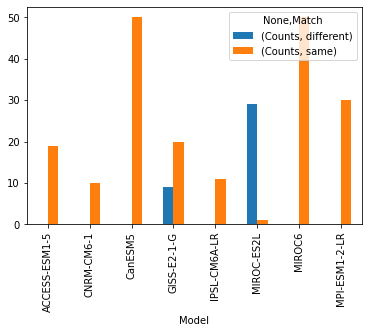

In [73]:
# summary plot of results
dfGModel = dfModel.groupby(['Model', 'Match']).size().reset_index(name = 'Counts')
plot = dfGModel.pivot_table(index = 'Model', columns = 'Match', fill_value = 0).plot(kind = 'bar')

In [75]:
# saving the output to a csv
MakeChangeDir(statsDir)

dfModel.to_csv('Parent_variant_matches.csv', index = True)

In [78]:
file

<xarray.Dataset>
Dimensions:    (time: 60, bnds: 2, lat: 90, lon: 144)
Coordinates:
  * time       (time) object 2020-01-16 12:00:00 ... 2024-12-16 12:00:00
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    ts         (time, lat, lon) float32 ...
Attributes: (12/49)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     ScenarioMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           0.0
    contact:                         Kenneth Lo (cdkkl@giss.nasa.gov)
    ...                              ...
    tracking_id:                     hdl:21.14100/cb99381f-35e5-4053-8eac-709...
    variable_id:                     ts
    variant_label:                   r9i1p5f2
    license:                         CMIP6 model data produced by NASA Goddar...
    cmor_version:                    3.3.2
    DODS_EXTRA.Unlimited_Dimension:  time